In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
np.set_printoptions(precision=3)
pd.set_option("precision",3)
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
# 경고메시지 무시
import warnings
warnings.filterwarnings("ignore")

In [3]:
batting_2018 = pd.read_csv('data/2018_batting.csv', encoding='cp949')
batting_2019 = pd.read_csv('data/2019_batting.csv', encoding='cp949')
batting_2020 = pd.read_csv('data/2020_batting.csv', encoding='cp949')
batting_2021 = pd.read_csv('data/2021_batting.csv', encoding='cp949')

batting = pd.concat([batting_2018, batting_2019,
                     batting_2020, batting_2021])

# GYEAR : 연도
# G_ID : 경기코드
# PIT_ID : 타구코드
# PCODE : 선수코드
# T_ID : 타자 팀 코드
# INN : 이닝
# HIT_VEL : 타구속도(km/h)
# HIT_ANG_VER : 발사각도
# HIT_RESULT : 타석결과 - 자세한 설명은 아래에서
# PIT_VEL : 상대투수 타구구속(km/h) 
# STADIUM : 해당구장

In [4]:
# 컬럼명 바꾸기

batting.columns = ['연도','경기코드','타구코드','선수코드',
                   '팀코드','이닝','타구속도','발사각도',
                   '타석결과','상대투수 타구구속','구장']

batting = batting[['연도','선수코드','경기코드','타구코드',
                  '팀코드','이닝','타구속도','발사각도',
                  '타석결과','상대투수 타구구속','구장']]

# 비거리 체공시간에 필요하다고 생각되는 데이터
batting 변수에 타구별 발사각도, 타구속도 데이터가 있습니다.

# 비행거리 계산.

1. 타구 속도 = $v$ 일때 지면과의 수평 성분 = $v_x = v \cdot cos(\theta)$ 이며 수직 성분 = $v_y = v \cdot sin(\theta)$ 이다. 여기에서 $\theta$ 는 radian으로 표현된 발사 각도이다. (360도 = $2 \pi$ radian). 
<br>

2. 공기의 저항을 감안하지 않고 볼의 체공 시간 $t$는 다음과 같은 조건을 사용해서 계산할 수 있다. 
   $$ -g \cdot t^2/ 2 + v_y \cdot t + y_0 = 0 $$
   - 여기에서 $y_0$의 의미는 배트가 볼에 닿는 지면 부터의 거리(위치)이다.
   - 위 방정식은 이차 방정식이며, 다음과 같이 그 해를 구할 수 있다.
     $$ t= {{- v_y \pm \sqrt{v_y^2 + 2 g y_0}} \over{-g}} $$
   - $\pm$는 두 개의 해를 의미하는데 "$-$"의 부호를 선택해서 양수의 시간에 해당하는 $t$를 구한다.그러면, 
      $$ t= {{ v_y + \sqrt{v_y^2 + 2 g y_0}} \over{g}} $$
3. 마지막으로 공기의 저항을 감안하지 않고 계산한 비행거리는 다음과 같다.
$$ x_{비행거리} = v_x \cdot t =  v_x \cdot \left( {{ v_y + \sqrt{v_y^2 + 2 g y_0}} \over{g}}  \right)  $$

In [5]:
# 타구 속도에는 1000/3600를 곱해 주어서 kilo meter/hour 를 meter/second로 변환시킨다.
y0 = 1                                                         # 배트가 볼에 닿는 지면과의 거리.
g = 9.8                                                        # 중력의 가속도
batting["theta"] = batting["발사각도"]*2*np.pi/360                             # radian 발사 각도 
batting["vx"] = batting["타구속도"]*1000/3600*np.cos(batting["theta"])         # 수평 성분.  
batting["vy"] = batting["타구속도"]*1000/3600*np.sin(batting["theta"])         # 수직 성분.
batting["체공시간"] = (batting["vy"] + np.sqrt(batting["vy"]**2 + 2*g*y0))/g    # 체공 시간 (seconds)
batting["flight_distance"] = batting["vx"]*batting["체공시간"]                   # 비행거리 (미터).

# 공기 저항 (항력, drag)를 감안한 계산.

- 항력은 운동 방향의 반대 방향으로 적용되는 힘이며 속도가 높을 수록 강하게 적용된다.
- 공의 발사 각도는 대다수의 경우 45도 이하이다. 즉 수평 성분이 수직 성분 보다 더 큰 상황이므로, 수평 성분에 더 큰 공기 저항이 적용된다. 
- 그러므로 항력이 지면과의 수평 성분에만 적용된다는 가정을 하겠다. 
- 항력은 다음 수식으로 주어진다.

$$ F_d = - {1\over{2}}  \rho \cdot v_x^2 \cdot A \cdot C_d  $$

- $\rho$ : 공기의 밀도. 예를 들어서 섭시 25도의 경우 1.1839 $[kg/m^3]$. 다음 [링크](https://en.wikipedia.org/wiki/Density_of_air)를 참고해 본다.
- $v_x$ : 공의 속도 (수평 성분).
- $A$: 공의 단면적. 공의 반지름 $r = 0.036 [m]$ 이므로 단면적은 $A = \pi r^2 = 0.00407 [m^2]$ 이다.
- $C_d$: 항력 계수. 다음 [논문](https://physics.csuchico.edu/baseball/Pubs/drag.pdf)에 의하면 $0.346$ 이다.

In [6]:
# 기상 데이터 가져오기
weather = pd.read_csv('data/weather.csv')

In [7]:
weather[(weather['날짜'] == '20180330') & (weather['지역명'] == '대전')] 

,지역명,날짜,평균기온,최저기온,최고기온,평균풍속,최다풍향,평균상대습도,평균증기압,평균현지기압,평균지면온도


In [8]:
weather.drop(columns=['최저기온', '최고기온', '평균풍속', '최다풍향', '평균상대습도', '평균지면온도'], inplace=True)

In [9]:
weather.loc[weather['평균현지기압'].isna()]
weather.loc[weather['평균증기압'].isna()]
weather.fillna(method='ffill', inplace=True)

In [10]:
# 병합을 위한 추가 전처리
# 날짜 형식 통합
weather['날짜'] = weather['날짜'].str.replace('-',"")
batting['날짜'] = batting['경기코드'].str[:8]

# 구장이 위치한 지역 추가
rn_dic = dict(zip(list(batting.구장.unique()),["서울","광주","창원","인천","서울","부산","수원","대전","대구",'창원']))
batting['지역명'] = batting['구장'].apply(lambda x: rn_dic[x])

In [11]:
# 데이터 병합 코드, 날짜 지역명 기준으로 병합
batting_weather = pd.merge(batting, weather, how='left', on=['날짜', '지역명'])
batting_weather

,연도,선수코드,경기코드,타구코드,팀코드,이닝,타구속도,발사각도,타석결과,상대투수 타구구속,...,theta,vx,vy,체공시간,flight_distance,날짜,지역명,평균기온,평균증기압,평균현지기압
0,2018,62797,20180324HHWO0,180324_140436,HH,1,131.50,42.7,플라이,149.59,...,0.745,26.845,24.772,5.095,136.787,20180324,서울,7.6,6.5,1011.8
1,2018,76753,20180324HHWO0,180324_140514,HH,1,135.18,9.9,1루타,148.78,...,0.173,36.991,6.456,1.458,53.916,20180324,서울,7.6,6.5,1011.8
2,2018,71752,20180324HHWO0,180324_140647,HH,1,152.41,2.1,1루타,148.59,...,0.037,42.308,1.551,0.637,26.949,20180324,서울,7.6,6.5,1011.8
3,2018,62700,20180324HHWO0,180324_140911,HH,1,113.72,13.5,1루타,139.13,...,0.236,30.716,7.374,1.630,50.072,20180324,서울,7.6,6.5,1011.8
4,2018,68730,20180324HHWO0,180324_142050,HH,2,54.11,16.4,번트안타,134.07,...,0.286,14.419,4.244,1.059,15.267,20180324,서울,7.6,6.5,1011.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120740,2021,50458,20210711LTSS0,210711_195321,SS,8,141.23,-4.9,땅볼아웃,137.76,...,-0.086,39.087,-3.351,0.225,8.780,20210711,대구,25.7,23.8,1004.4
120741,2021,62415,20210711LTSS0,210711_195424,SS,8,101.09,31.8,1루타,138.51,...,0.555,23.865,14.797,3.086,73.648,20210711,대구,25.7,23.8,1004.4
120742,2021,75566,20210711LTSS0,210711_195627,SS,8,146.84,33.4,홈런,134.10,...,0.583,34.053,22.453,4.626,157.543,20210711,대구,25.7,23.8,1004.4
120743,2021,69418,20210711LTSS0,210711_200047,SS,8,146.12,23.9,홈런,139.96,...,0.417,37.109,16.444,3.416,126.752,20210711,대구,25.7,23.8,1004.4


- 습한 공기

# $$ \rho _{humid \ air} = { { p_dM_d + p_vM_v } \over{RT} } $$

- $\rho _{humid \ air}$ : 습한 공기의 밀도. $(kg/m^3)$.
- $p_d$ : 건조한 공기의 부분압  $(Pa)$.
- $p_v$ : 증기압  $(Pa)$.
- $M_d$: 건조 공기의 몰 질량. 다음 [링크](https://en.wikipedia.org/wiki/Density_of_air)에 의하면 0.0289652 kg/mol 입니다.
- $M_v$: 수증기의 몰 질량. 다음 [링크](https://en.wikipedia.org/wiki/Density_of_air)에 의하면 0.018016 kg/mol 입니다.
- $T$ : 절대 온도  $(K)$. 주어진 온도의 단위는 섭씨$(^oC)$ 이므로 절대 온도는 $K = 273.15 + ^oC$로 구한다.
- $R$: 기체 상수. 다음 [링크](https://en.wikipedia.org/wiki/Density_of_air)에 의하면 8.31446 J/(kg·K)입니다.

- ASOS 데이터에 증기압 변수가 존재하기 때문에 습한 공기의 공식을 사용한다

In [12]:
# 공기 밀도 구하기
batting_weather['rho'] = (batting_weather['평균증기압'] * 0.018016 + batting_weather['평균현지기압'] * 0.0289652 ) * 100 / (8.31446 * (batting_weather['평균기온'] + 273.15)) 

$$ F_d = - a \cdot v_x^2   $$

In [13]:
# a를 계산하는 방법.
batting_weather['a'] = 0.5*batting_weather['rho']*0.00407*0.346

- 이제 수평 방향으로의 역학 미분 방정식은 다음과 같이 표현할 수 있다.
- 여기에서 $m = 0.145 [kg]$는 야구 공의 무게이다.
$$ m{{d^2x}\over{dt^2}} = F_d = -a \cdot \left({{dx}\over{dt}} \right)^2 $$

$$ {{dv_x}\over{dt}} = -{{a}\over{m}} \cdot v_x^2 $$

- 위의 미분 방적식의 해는 다음과 같다. $v_x(0)$ 는 초기 수평 속도 성분이다.

$$v_x(t) = {{1}\over{{a\over{m}}t + 1/v_x(0)}} $$

- 위 방적식을 한번 더 적분하면 다음과 같은 해를 구할 수 있다. 초기 위치 $x(0)=0$ 임을 전제 하였다.

In [14]:
#위에서 a/m을 b 라는 이름으로 제장해 둔다.
m = 0.145
batting_weather['b'] = batting_weather['a']/m

$$ x(t) = { { log\left( {a\over{m}}t + 1/v_x(0) \right) } \over{{a\over{m}}}} - { { log\left( 1/v_x(0) \right) } \over{{a\over{m}}}} $$

In [15]:
# 공기의 항력을 감안한 비행거리!
batting_weather["비거리"] = np.log(batting_weather['b']*batting_weather["체공시간"] + 1/batting_weather["vx"])/batting_weather['b']  - np.log(1/batting_weather["vx"])/batting_weather['b']            # 비행거리 (미터).

In [16]:
# 속도 단위 변화 km/h→mhp
batting_weather['타구속도'] = batting_weather['타구속도'] * 0.621371

In [17]:
# 필요 변수 추출 (수정함-수연)
batting_weather = batting_weather[['날짜','선수코드','타구속도','발사각도', '타석결과','체공시간','비거리']]

In [18]:
# 타석 결과 변수 처리, 장타율 1.5 이상을 가지는 타석 결과(2루타, 3루타, 홈런 → 1, 나머지 → 0) 

colors = [] #리스트 생성 
batting_weather['colors'] = 0

for bat in batting_weather['타석결과']:
    if bat == '홈런': 
        colors.append(1)
    elif bat == '2루타': 
        colors.append(1) 
    elif bat == '3루타': 
        colors.append(1) 
    elif bat == '1루타': 
        colors.append(0)         
    else: 
        colors.append(0)

batting_weather['colors'] = colors #colors열에 순차대로 원소를 대입

In [19]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드
features = ['비거리', '타구속도', '발사각도', '체공시간']
X = np.asarray(batting_weather[features])
y = np.asarray(batting_weather['colors'])

# 훈련/테스트 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [20]:
# DecisionTree모델 생성과 학습
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 8,random_state=0)
model.fit(X_train, y_train)
# 평가
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9159212880143113, 0.9131745453340842)

array([0.512, 0.347, 0.129, 0.012])

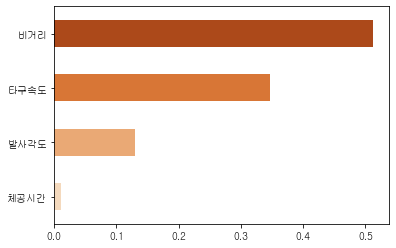

In [21]:
# 특성 중요도 시각화
fig, ax = plt.subplots()
palette = sns.color_palette("Oranges", 4)[::-1]
sns.barplot(x=model.feature_importances_, y=features, palette=palette)
# ['tab:orange', 'tab:olive', 'tab:pink', 'tab:red']
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .50)
model.feature_importances_

In [22]:
# XGBoost모델 생성과 학습
from xgboost import XGBClassifier

model = XGBClassifier(random_state=0, max_depth=10)
model.fit(X_train, y_train)

# 평가
model.score(X_train, y_train), model.score(X_test, y_test)

[04:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.930254643432938, 0.9126113890085136)

In [23]:
# SHAP을 사용하여 모델의 예측을 설명한다.
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

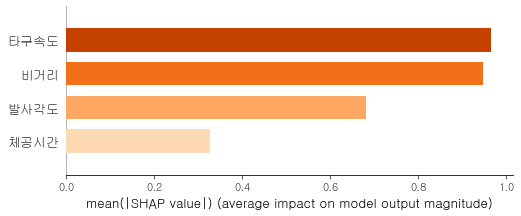

In [24]:
# XGBoost모델에 SHAP을 사용하여 특성 중요도 시각화
shap.summary_plot(shap_values, X_train, color=palette[::-1] ,feature_names=features, plot_type='bar')

# 타격데이터 이상치 제거

In [25]:
batting_test = batting_weather.copy()

In [26]:
# 홈런이 아닌 타구 중에 비거리 130m이상 제거
idx_nm_1 = batting_test[(batting_test['타석결과'] != '홈런')&(batting_test['비거리'] >= 130)].index
batting_test.drop(idx_nm_1, inplace=True)

# 홈런 타구 중에 비거리 100m이하 또는 발사각도 10도 이하 제거
idx_nm_2 = batting_test[(batting_test['타석결과'] == '홈런')&((batting_test['비거리'] <= 100)|(batting_test['발사각도'] <= 10))].index
batting_test.drop(idx_nm_2, inplace=True)

# 2루타 중에 짧은 비거리 또는 발사 각도가 10도 이하 제거
idx_nm_2 = batting_test[(batting_test['타석결과'] == '2루타')&((batting_test['비거리'] <= 53.875)|(batting_test['발사각도'] <= 10))].index
batting_test.drop(idx_nm_2, inplace=True)

# 3루타 중에 짧은 비거리 또는 발사 각도가 10도 이하 제거
idx_nm_3 = batting_test[(batting_test['타석결과'] == '3루타')&((batting_test['비거리'] <= 53.875)|(batting_test['발사각도'] <= 10))].index
batting_test.drop(idx_nm_3, inplace=True)

In [27]:
# 타석 결과 변수 처리, 장타율 1.5 이상을 가지는 타석 결과(2루타, 3루타, 홈런 → 1, 나머지 → 0) 

colors = [] #리스트 생성 
batting_test['colors'] = 0

for bat in batting_test['타석결과']:
    if bat == '홈런': 
        colors.append(1)
    elif bat == '2루타': 
        colors.append(1) 
    elif bat == '3루타': 
        colors.append(1) 
    elif bat == '1루타': 
        colors.append(0)         
    else: 
        colors.append(0)

batting_test['colors'] = colors #colors열에 순차대로 원소를 대입

In [28]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드
features = ['타구속도', '발사각도', '비거리', '체공시간']
features_im1 = ['비거리', '체공시간']
features_im2 = ['타구속도', '발사각도']

X = np.asarray(batting_test[features_im1])
y = np.asarray(batting_test['colors'])

# 훈련/테스트 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [29]:
from sklearn.linear_model import SGDClassifier

# 비거리와 체공 시간으로 배럴 정의하는 모델 구현
model = SGDClassifier(max_iter=10000, random_state=0)
model.fit(X_train, y_train)
model.coef_, model.intercept_

(array([[  13.65 , -149.826]]), array([-813.162]))

In [30]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9273712062960785, 0.9257098273347129)

In [31]:
pred_Barrel = model.predict(X)
batting_test['predict'] = pred_Barrel

In [32]:
# 배럴 타구 최소 비거리
batting_test[batting_test['predict']==1].비거리.min()

87.11778128936896

In [33]:
# 배럴 타구 최소 체공시간
batting_test[batting_test['predict']==1].체공시간.min()

2.4372901656274495

In [34]:
# 배럴 타구 최대 체공시간
batting_test[batting_test['predict']==1].체공시간.min()

2.4372901656274495

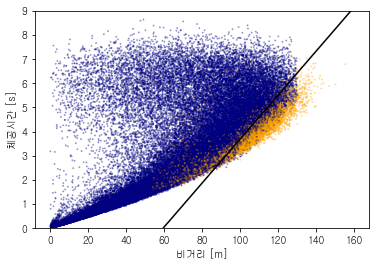

In [35]:
# 모델의 배럴 정의 시각화
w0 = model.coef_[0, 0]
w1 = model.coef_[0, 1]
b = model.intercept_
# colors = ['Blue', "Orange"]
def color_change(x):
    if x == 0:
        return 'navy'
    else:
        return 'orange'
    
yy = [color_change(x) for x in y_train]

plt.scatter(X_train[:, 0], X_train[:, 1], c=yy, alpha = 0.3,s=1, cmap='Pastel1')
x0 = np.linspace(0, 160, 100)
x1 = -(w0 * x0 + b) / w1
plt.plot(x0, x1,color = "black")
plt.xlabel('비거리 [m]')
plt.ylim(0,9)
plt.ylabel('체공시간 [s]')

# plt.legend(['barrel','non-barrel'])

plt.show()

In [36]:
# 발사각도와 타구속도 기준으로 
X = np.asarray(batting_test[features_im2])
y = np.asarray(batting_test['colors'])

# 훈련/테스트 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [37]:
from sklearn.preprocessing import PolynomialFeatures

# 발사각도를 2차원로 한 특성 추가
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(X[:, 1].reshape(-1, 1))
X_poly = np.hstack([x_poly,X[:, 0].reshape(-1, 1)])
X_poly.shape, X.shape

((117915, 3), (117915, 2))

In [38]:
# 훈련/테스트 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=0)

In [39]:
from sklearn.linear_model import SGDClassifier

# 발사각도를 타구속도로 배럴 정의하는 모델 구현
model = SGDClassifier(max_iter=10000, random_state=0)
model.fit(X_train, y_train)
model.coef_, model.intercept_

(array([[45.124, -0.932,  7.185]]), array([-1111.668]))

In [40]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8650775702202723, 0.8631907459547474)

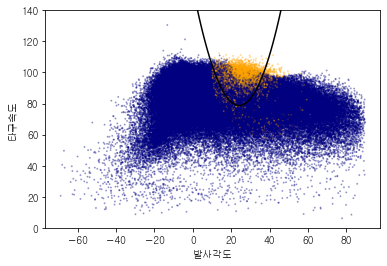

In [41]:
# 모델의 배럴 정의 시각화

w0 = model.coef_[0, 0]
w1 = model.coef_[0, 1]
w2 = model.coef_[0, 2]
b = model.intercept_
# colors = ['Blue', "Orange"]
def color_change(x):
    if x == 0:
        return 'navy'
    else:
        return 'orange'
    
yy = [color_change(x) for x in y]

plt.scatter(X_poly[:, 0], X_poly[:, 2], c=yy, alpha = 0.3,s=1, cmap='Pastel1')
x0 = np.linspace(-20, 80, 100)
x1 = -(w0 * x0 + w1 * x0 * x0 + b) / w2
plt.plot(x0, x1,color = "black")
plt.xlabel('발사각도')
plt.ylim(0,140)
plt.ylabel('타구속도')

plt.show()

# 회귀분석

In [42]:
batting_test.head()

,날짜,선수코드,타구속도,발사각도,타석결과,체공시간,비거리,colors,predict
0,20180324,62797,81.710,42.7,플라이,5.095,99.377,0,0
1,20180324,76753,83.997,9.9,1루타,1.458,46.593,0,0
2,20180324,71752,94.703,2.1,1루타,0.637,24.944,0,0
3,20180324,62700,70.662,13.5,1루타,1.630,43.676,0,0
4,20180324,68730,33.622,16.4,번트안타,1.059,14.595,0,0


### 배럴률 구하기

In [43]:
# 월별 선수들의 배럴률 집계
batting_test["월별"] = batting_test["날짜"].apply(lambda x:x[:-2])
batting_test = batting_test.drop(["날짜","colors"],axis=1)

df = batting_test.groupby(["월별","선수코드"])['predict'].count().reset_index()
df_barrel = batting_test.groupby(["월별","선수코드"])['predict'].sum().reset_index()

df["배럴률"] = df_barrel["predict"] / df["predict"]
barrel_df = df.drop(['predict'],axis=1)

In [44]:
barrel_df.head()

,월별,선수코드,배럴률
0,201803,60100,0.000
1,201803,60343,0.250
2,201803,60558,0.083
3,201803,60566,0.000
4,201803,61102,0.000


### 장타율 구하기

In [45]:
# 데이터 불러오기
batting_2018 = pd.read_csv('data/2018_batting.csv', encoding='cp949')
batting_2019 = pd.read_csv('data/2019_batting.csv', encoding='cp949')
batting_2020 = pd.read_csv('data/2020_batting.csv', encoding='cp949')
batting_2021 = pd.read_csv('data/2021_batting.csv', encoding='cp949')

batting = pd.concat([batting_2018, batting_2019,
                     batting_2020, batting_2021])

batting.columns = ['연도','경기코드','타구코드','선수코드',
                   '팀코드','이닝','타구속도','발사각도',
                   '타석결과','구속','구장']

batting.head()

,연도,경기코드,타구코드,선수코드,팀코드,이닝,타구속도,발사각도,타석결과,구속,구장
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척
4,2018,20180324HHWO0,180324_142050,68730,HH,2,54.11,16.4,번트안타,134.07,고척


In [46]:
# 타수 집계
batting_df = batting[["경기코드","선수코드","팀코드","타석결과"]]
batting_df["월별"] = batting_df["경기코드"].apply(lambda x:x[:6])
batting_count = batting_df.groupby(["월별","선수코드"])["타석결과"].count().reset_index()

In [47]:
# 월별 선수 타석결과 집계
batting_df = pd.get_dummies(batting_df, columns = ['타석결과'])

batting_df = batting_df[['월별','선수코드','타석결과_1루타', '타석결과_2루타', '타석결과_3루타',
       '타석결과_내야안타(1루타)', '타석결과_홈런', '타석결과_희생플라이']]

batting_df.columns = ["월별","선수코드","1루타","2루타","3루타","내야안타","홈런","희생플라이"]

batting_df["1루타"] = batting_df["1루타"] + batting_df["내야안타"]

df_grouped = batting_df.groupby(["월별","선수코드"]).sum().reset_index()


In [48]:
# 월별 선수 장타율 변수 생성
df_final = pd.merge(df_grouped, batting_count, on = ['월별','선수코드'] , how = 'inner')
df_final.columns = ['월별', '선수코드', '1루타', '2루타', '3루타', '내야안타', '홈런', '희생플라이', '타수']

df_final['장타율'] = (df_final['1루타']+(df_final['2루타']*2)+(df_final['3루타']*3)+(df_final['홈런']*4)) / df_final['타수']
slg_df = df_final[["월별","선수코드","장타율"]]

In [49]:
# 배렬률 데이터프레임과 장타율 데이터프레임 inner join
df = pd.merge(slg_df, barrel_df, on = ['월별','선수코드'] , how = 'inner')
df.head()

,월별,선수코드,장타율,배럴률
0,201803,60100,0.000,0.000
1,201803,60343,1.250,0.250
2,201803,60558,0.500,0.083
3,201803,60566,0.636,0.000
4,201803,61102,0.643,0.000


### OLS Regression

In [50]:
import statsmodels.api as sm

df['intercept'] = 1

lm = sm.OLS(df['장타율'], df[['intercept',"배럴률"]])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    장타율   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1304.
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          8.54e-252
Time:                        04:19:42   Log-Likelihood:                -886.65
No. Observations:                4623   AIC:                             1777.
Df Residuals:                    4621   BIC:                             1790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4112      0.005     80.470      0.000       0.401       0.421
배럴률            1.6012      0.044     36.114      0.000       1.514       1.688
==============================================================================
Omnibus:                     1241.793   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25601.910
Skew:                           0.771   Prob(JB):                         0.00
Kurtosis:                      14.425   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""